purpose: translate Rat GWAS into human orthologs (and maybe human to rat once a co-expression network made). After ortholog mapping, define seed gene sets. For ortho mapping- using bestmatch.

# Set-up

In [8]:
import os
import pandas as pd
import statsmodels.stats.multitest
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

# define ortholog dictionary

In [4]:
ortho=pd.read_csv('/tscc/projects/ps-palmer/brittany/orthology_ref_tbls/ORTHOLOGY-ALLIANCE_COMBINED_2024.tsv',sep='\t',skiprows=15)
#downloaded from https://www.alliancegenome.org/downloads#orthology on 11 June 2024
#filter for rat-human
ortho=ortho[(ortho['Gene1SpeciesName']=='Rattus norvegicus')&(ortho['Gene2SpeciesName']=='Homo sapiens')]
#filter for best match
ortho=ortho[ortho['IsBestScore']=='Yes']

In [5]:
ortho_best=ortho[ortho['IsBestScore']=='Yes']
ortho_best

,Gene1ID,Gene1Symbol,Gene1SpeciesTaxonID,Gene1SpeciesName,Gene2ID,Gene2Symbol,Gene2SpeciesTaxonID,Gene2SpeciesName,Algorithms,AlgorithmsMatch,OutOfAlgorithms,IsBestScore,IsBestRevScore
422849,RGD:69417,A1bg,NCBITaxon:10116,Rattus norvegicus,HGNC:5,A1BG,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,10,10,Yes,Yes
422851,RGD:619834,A1cf,NCBITaxon:10116,Rattus norvegicus,HGNC:24086,A1CF,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes
422857,RGD:2004,A2m,NCBITaxon:10116,Rattus norvegicus,HGNC:7,A2M,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,10,10,Yes,Yes
422866,RGD:727913,A3galt2,NCBITaxon:10116,Rattus norvegicus,HGNC:30005,A3GALT2,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,10,10,Yes,Yes
422868,RGD:621583,A4galt,NCBITaxon:10116,Rattus norvegicus,HGNC:18149,A4GALT,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
567804,RGD:1309582,Zyg11a,NCBITaxon:10116,Rattus norvegicus,HGNC:32058,ZYG11A,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,9,10,Yes,Yes
567811,RGD:1307814,Zyg11b,NCBITaxon:10116,Rattus norvegicus,HGNC:25820,ZYG11B,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes
567819,RGD:620698,Zyx,NCBITaxon:10116,Rattus norvegicus,HGNC:13200,ZYX,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,9,10,Yes,Yes
567823,RGD:1311189,Zzef1,NCBITaxon:10116,Rattus norvegicus,HGNC:29027,ZZEF1,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes


In [17]:
ortho_best_both=ortho_best[ortho_best['IsBestRevScore']=='Yes']

lose 1753 genes if filter for best reverse

In [7]:
ortho[ortho['AlgorithmsMatch']>2]

,Gene1ID,Gene1Symbol,Gene1SpeciesTaxonID,Gene1SpeciesName,Gene2ID,Gene2Symbol,Gene2SpeciesTaxonID,Gene2SpeciesName,Algorithms,AlgorithmsMatch,OutOfAlgorithms,IsBestScore,IsBestRevScore
422849,RGD:69417,A1bg,NCBITaxon:10116,Rattus norvegicus,HGNC:5,A1BG,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,10,10,Yes,Yes
422851,RGD:619834,A1cf,NCBITaxon:10116,Rattus norvegicus,HGNC:24086,A1CF,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes
422857,RGD:2004,A2m,NCBITaxon:10116,Rattus norvegicus,HGNC:7,A2M,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,10,10,Yes,Yes
422866,RGD:727913,A3galt2,NCBITaxon:10116,Rattus norvegicus,HGNC:30005,A3GALT2,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,10,10,Yes,Yes
422868,RGD:621583,A4galt,NCBITaxon:10116,Rattus norvegicus,HGNC:18149,A4GALT,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
567804,RGD:1309582,Zyg11a,NCBITaxon:10116,Rattus norvegicus,HGNC:32058,ZYG11A,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,9,10,Yes,Yes
567811,RGD:1307814,Zyg11b,NCBITaxon:10116,Rattus norvegicus,HGNC:25820,ZYG11B,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes
567819,RGD:620698,Zyx,NCBITaxon:10116,Rattus norvegicus,HGNC:13200,ZYX,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,9,10,Yes,Yes
567823,RGD:1311189,Zzef1,NCBITaxon:10116,Rattus norvegicus,HGNC:29027,ZZEF1,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes


lose 1006 if filter for >2 databases rather than best ortholog

# Read in rat genes (MAGMA)

In [65]:
loco_magma=pd.read_csv('magma/loco_meta_win10.genes.out',delim_whitespace=True,index_col=None,skiprows=1)

In [66]:
loco_magma

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P
0,Vom2r5,1,1151906,1180559,2,1,8679,1.639900,0.050510
1,Vom2r6,1,1204035,1232755,2,1,8679,1.853600,0.031899
2,LOC102547284,1,1735535,1764558,3,1,8679,0.322850,0.373400
3,Raet1c,1,1781462,1806110,2,1,8679,-0.002043,0.500820
4,LOC120093164,1,1797226,1822755,2,1,8679,-0.002043,0.500820
...,...,...,...,...,...,...,...,...,...
18942,Ascc3,20,53500137,53805446,340,1,8679,0.449350,0.326590
18943,Sim1,20,53817601,53917219,148,1,8679,0.479350,0.315840
18944,LOC103694460,20,54404724,54428200,56,1,8679,0.434780,0.331860
18945,Cd99,20,54408239,54432882,53,1,8679,0.439540,0.330130


In [23]:
len(set(ortho_best['Gene1Symbol']))-len(set(ortho_best['Gene2Symbol']))

1002

In [22]:
len(set(ortho_best_both['Gene1Symbol']))-len(set(ortho_best_both['Gene2Symbol']))

27

# test cutoffs

## bonferroni

In [47]:
0.05/len(loco_magma)

2.6389402016150313e-06

In [41]:
loco_magma[loco_magma['P']<0.05/len(loco_magma)]

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P
1845,Dmbt1,1,185607469,185706476,157,4,8679,5.5261,1.637200e-08
1846,LOC100911413,1,185714946,185910431,317,8,8679,4.6474,1.680300e-06
1847,C1h10orf120,1,185900420,185923478,99,5,8679,4.7282,1.132500e-06
1849,Cuzd1,1,186079422,186140536,226,5,8679,4.8517,6.120200e-07
1850,RGD1559891,1,186098544,186121598,73,4,8679,4.6256,1.867800e-06
1851,Fam24b,1,186102544,186125957,67,4,8679,4.6604,1.578000e-06
1852,Fam24a,1,186109918,186132932,70,4,8679,4.5788,2.338500e-06
1857,Hmx3,1,186303237,186325201,19,2,8679,5.7666,4.045400e-09
1858,Hmx2,1,186309110,186336771,22,3,8679,5.9155,1.654600e-09
1859,Bub3,1,186320358,186350969,34,3,8679,6.1057,5.116400e-10


## FDR

In [111]:
#compare before and after ortholog mapping
loco_magma['FDR_corr']=statsmodels.stats.multitest.fdrcorrection(loco_magma['P'],alpha=0.05,method='indep',is_sorted=False)[1]

(array([1098., 1535., 1446., 1535., 1574., 2094., 2483., 2560., 2107.,
        2515.]),
 array([9.69404308e-06, 9.99147246e-02, 1.99819755e-01, 2.99724786e-01,
        3.99629816e-01, 4.99534847e-01, 5.99439878e-01, 6.99344908e-01,
        7.99249939e-01, 8.99154969e-01, 9.99060000e-01]),
 <BarContainer object of 10 artists>)

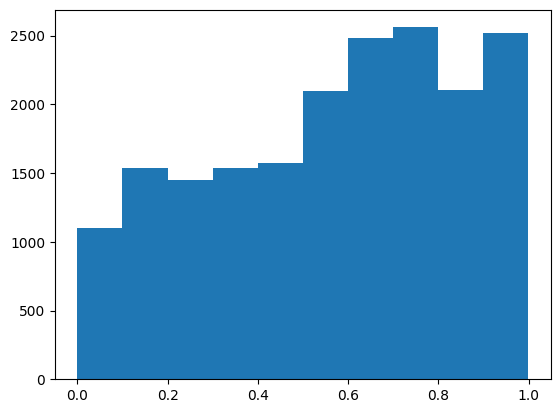

In [113]:
plt.hist(loco_magma['FDR_corr'])

In [114]:
loco_magma[loco_magma['FDR_corr']<0.05]

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P,FDR_corr
28,Shprh,1,5518827,5612537,278,8,8679,3.1907,0.000710,0.043479
29,Fbxo30,1,5645341,5681558,98,4,8679,3.4270,0.000305,0.034412
34,Plagl1,1,7467295,7527229,185,7,8679,3.0682,0.001077,0.049377
37,Phactr2,1,7581254,7870431,1045,16,8679,3.1001,0.000967,0.048165
38,Fuca2,1,7875986,7910777,123,8,8679,3.5956,0.000162,0.029140
...,...,...,...,...,...,...,...,...,...,...
18045,Rnf150,19,24996978,25239273,742,20,8679,3.2235,0.000633,0.041307
18046,Zfp330,19,25303655,25334958,170,3,8679,3.2992,0.000485,0.039562
18049,Inpp4b,19,25910189,26680085,2790,23,8679,3.2551,0.000567,0.040522
18052,Smarca5,19,27261918,27314594,112,5,8679,3.1397,0.000846,0.045998


# merge in human orthologs

In [119]:
loco=loco_magma.merge(ortho_best[['Gene1Symbol','Gene2Symbol']], left_on='GENE',right_on='Gene1Symbol',how='left').dropna().reset_index().drop(['index','Gene1Symbol'],axis=1)
loco.columns=['GENE', 'CHR', 'START', 'STOP', 'NSNPS', 'NPARAM', 'N', 'ZSTAT', 'P',
       'Q', 'HM_ORTHO']

In [163]:
loco

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P,Q,HM_ORTHO
0,Raet1l,1,1969433,1994410,2,1,8679,0.852480,0.19698,0.506814,RAET1E
1,Lrp11,1,2038307,2118115,149,4,8679,0.229650,0.40918,0.684323,LRP11
2,Pcmt1,1,2101756,2170354,149,3,8679,0.369610,0.35583,0.648259,PCMT1
3,Nup43,1,2134427,2167887,70,3,8679,0.295030,0.38398,0.668305,NUP43
4,Lats1,1,2150411,2203640,57,3,8679,-0.004605,0.50184,0.742480,LATS1
...,...,...,...,...,...,...,...,...,...,...,...
16499,Hace1,20,49025312,49161103,203,5,8679,-1.330900,0.90839,0.959165,HACE1
16500,Grik2,20,52125325,52843061,1295,2,8679,-0.103500,0.54122,0.766618,GRIK2
16501,Ascc3,20,53500137,53805446,340,1,8679,0.449350,0.32659,0.627184,ASCC3
16502,Sim1,20,53817601,53917219,148,1,8679,0.479350,0.31584,0.619741,SIM1


In [164]:
loco.to_csv('magma/seed_genes/loco_win10_annot.tsv',sep='\t', index=False)

# externalizing

In [3]:
set=['munged','orig']
file=set[1]

In [4]:
ext_magma=pd.read_csv('magma/ext_'+file+'.genes.out',delim_whitespace=True,index_col=None,skiprows=0)

In [5]:
gene_loc=pd.read_csv('/tscc/projects/ps-palmer/brittany/magma_v1/NCBI38/NCBI38.gene.loc',sep='\t',header=None)
gene_loc.columns=['ID','CHR','START','STOP','STAND','GENE_NAME']

In [6]:
ext_magma=gene_loc[['ID','GENE_NAME']].merge(ext_magma, left_on='ID',right_on='GENE',how='right').reset_index().drop(['index','GENE'],axis=1)
ext_magma.columns=['ID', 'GENE', 'CHR', 'START', 'STOP', 'NSNPS', 'NPARAM', 'N','ZSTAT', 'P']

In [9]:
ext_magma['Q']=statsmodels.stats.multitest.fdrcorrection(ext_magma['P'],alpha=0.05,method='indep',is_sorted=False)[1]

In [10]:
ext_magma.to_csv('magma/seed_genes/ext_'+file+'_annot.tsv',sep='\t',index=False)